# Regression

## 1. Introduction

We use the [Gas Turbine Dataset](https://archive.ics.uci.edu/ml/datasets/Gas+Turbine+CO+and+NOx+Emission+Data+Set#) for this task: similar to the paper, 2011, 2012 and 2013 are used as training datasets, and 2014/2015 are used for prediction. We have to predict two target variables: CO and NOX, and output them in a CSV file with the columns SNO,CO,NOX.

In [1]:
def evaluate_numeric(output_file):

    out_df = pd.read_csv(f'regression/outputs/{output_file}').set_index('SNO')
    ans_df = pd.read_csv('data/gas_emission/test_results.csv').set_index('SNO')

    MSE = (out_df-ans_df)**2

    print("RMSE:")
    print(MSE.pow(0.5).mean(axis=0))

## 2. Baseline predictions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df = pd.read_csv("data/gas_emission/train.csv").set_index('SNO')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22191 entries, 0 to 22190
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      22191 non-null  float64
 1   AP      22191 non-null  float64
 2   AH      22191 non-null  float64
 3   AFDP    22191 non-null  float64
 4   GTEP    22191 non-null  float64
 5   TIT     22191 non-null  float64
 6   TAT     22191 non-null  float64
 7   TEY     22191 non-null  float64
 8   CDP     22191 non-null  float64
 9   CO      22191 non-null  float64
 10  NOX     22191 non-null  float64
dtypes: float64(11)
memory usage: 2.0 MB


A nice reason to choose this dataset: imputation is none of our business. All clean, nice, non-null values.

We'll use Kernel Density Estimation for a baseline: basically, generate a PDF that looks like the distribution of data, and then generate data randomly from that distribution. We're assuming CO and NOX are not correlated (and it doesn't look like it as well

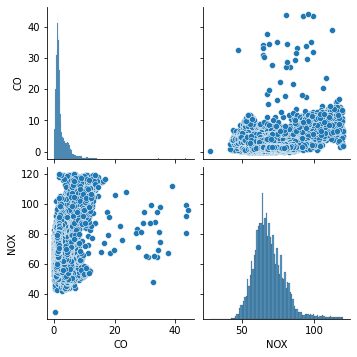

In [4]:
sns.pairplot(df[['CO','NOX']])

In [5]:
from sklearn.neighbors import KernelDensity

test_df = pd.read_csv("data/gas_emission/test.csv").set_index('SNO')

co_kde = KernelDensity(kernel='tophat', bandwidth=0.5).fit(df['CO'].to_numpy().reshape(-1,1))
co_preds = co_kde.sample(len(test_df))
nox_kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(df['NOX'].to_numpy().reshape(-1,1))
nox_preds = nox_kde.sample(len(test_df))

out_df = pd.DataFrame({'CO': np.squeeze(co_preds), 'NOX': np.squeeze(nox_preds)}, index=test_df.index)
out_df.to_csv('regression/outputs/baseline_predictions.csv')

In [6]:
evaluate_numeric('baseline_predictions.csv')

RMSE:
CO      1.970084
NOX    13.856483
dtype: float64


Cool, we have a baseline value that we can aim for now.

## 3. Linear Regression

### 3.1: Normal Form

The normal form equations use the moore-penrose pseudoinverse of the design matrix (Bishop)
$$\begin{align}
\mathbf{w} = (\Phi^T \Phi)^{-1} \Phi^T \textbf{T}
\end{align}
$$

Our design matrix here is going to be the matrix of transformations applied to datapoints in x (for now, it's identity for each index, and 1 for $\phi_0(x)$ to add the regression constant), and $\textbf{T}$ is the set of targets corresponding to each explanatory variable, in a matrix, each of whose column vectors represent targets of a different dependent variable.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class NormalLinearRegressor(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.w = None
        self.residuals = None
    
    def fit(self,X,T=None):
        phi = X.to_numpy(copy=True)
        T = T.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        self.w = np.linalg.inv(phi.T@phi)@phi.T@T
        
        self.residuals = T - self.predict(X)
        return self
        
    def predict(self,X):
        phi = X.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        preds = phi@self.w
        return preds

In [8]:
X = df.drop(['CO','NOX'],axis=1)
T = df[['CO','NOX']]

def regress(output, regressor):
    regressor.fit(X,T=T)
    preds = regressor.predict(test_df)
    res = regressor.residuals.copy()

    out = pd.DataFrame(preds, columns=['CO','NOX'], index=test_df.index)
    out.to_csv(f"regression/outputs/{output}")
    
    return res

residuals = regress("normal_regression_predictions.csv", NormalLinearRegressor())

In [9]:
evaluate_numeric('normal_regression_predictions.csv')

RMSE:
CO     1.321970
NOX    8.242453
dtype: float64


Nice! Clearly better than random guessing.

### 3.2: Assumptions of the Regression Model

The _residual_ is the difference between any datapoint and the regression plane fitted by the model.

1. **Linearity**: The relationship between X and the mean of Y is linear. An easy way of checking this for univariate regression is to simply plot X versus Y, but for multivariate regression, we use a scatter plot of residual versus predicted value: a _horizontal band of points_ indicates a linear relationship.
2. **Homoscedasticity**: The variance of the residual is the same for any value of X. A scatter plot of residuals versus fitted values should suffice for this.
3. **Independence**: Observations are independent of each other. Use the same plot as above.
4. **Normality of Errors**: The residuals must be normally ditributed (we use this assumption in the LL-derivation of the normal equations). A QQ (Quantile-Quantile) plot of the normal distribution v/s the residual distribution is plotted and the fit is observed.

For a good regression fit, we'll need to check each of these assumptions

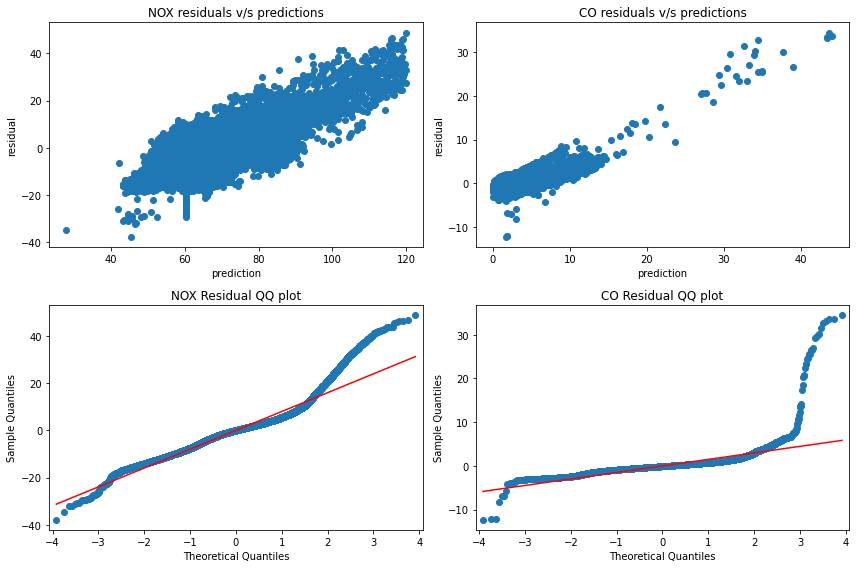

In [10]:
import statsmodels.api as sm


def print_residuals_QQ(res_NOX, res_CO, df):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0,0].scatter(x=df['NOX'],y=res_NOX)
    axs[0,0].set_title('NOX residuals v/s predictions')
    axs[0,0].set_xlabel('prediction')
    axs[0,0].set_ylabel('residual')

    axs[0,1].scatter(x=df['CO'],y=res_CO)
    axs[0,1].set_title('CO residuals v/s predictions')
    axs[0,1].set_xlabel('prediction')
    axs[0,1].set_ylabel('residual')

    sm.qqplot(res_NOX, ax=axs[1,0], line='s', markerfacecolor='C0', markeredgecolor='C0')
    axs[1,0].set_title('NOX Residual QQ plot')

    sm.qqplot(res_CO, ax=axs[1,1], line='s', markerfacecolor='C0', markeredgecolor='C0')
    axs[1,1].set_title('CO Residual QQ plot')

    plt.tight_layout()
    plt.show()
    
print_residuals_QQ(residuals[:,1], residuals[:,0], df)

Ouch! These are suboptimal. There's clearly heteroscedasticity, nonlinearity and everything else. We'll need to do a bit of feature engineering to make the fit better, but before that:

### 3.3: Goodness of Fit

The $R^2$ statistic measures the goodness of fit: how well the linear regression model explains the data. 

$$\begin{align}
R^2 &= 1 - \frac{SS_{res}}{SS_{tot}} \\
\text{where } SS_{res} &= \sum_i e_i^2 \\
SS_{tot} &= \sum_{i} (y_i - \overline{y})^2
\end{align}$$

In [11]:
def print_r_sq(res, T):

    r_sq_nox = 1 - (res[:,1]**2).sum()/((T['NOX'] - T['NOX'].mean())**2).sum()
    r_sq_co = 1 - (res[:,0]**2).sum()/((T['CO'] - T['CO'].mean())**2).sum()

    print(f"r_sq_nox: {r_sq_nox}")
    print(f"r_sq_co: {r_sq_co}")
    
print_r_sq(residuals, T)

r_sq_nox: 0.47818394729115155
r_sq_co: 0.5783710093608008


$R^2$ should be >0.7 for an explainable model and >0.8 for a good one

## 4. Feature Engineering

Feature Engineering is not the main focus of this notebook, which is why I won't cover it in much detail. Unhide the following cells if you wish to proceed.

 The description says the following about the features:

In [12]:
pd.read_csv('data/gas_emission/description.csv')

,Description,Abbr,Unit,Min,Max,Mean
0,Ambient temperature,AT,C,6.23,37.10,17.71
1,Ambient pressure,AP,mbar,985.85,1036.56,1013.07
2,Ambient humidity,AH,(%),24.08,100.20,77.87
3,Air filter difference pressure,AFDP,mbar,2.09,7.61,3.93
4,Gas turbine exhaust pressure,GTEP,mbar,17.70,40.72,25.56
5,Turbine inlet temperature,TIT,C,1000.85,1100.89,1081.43
6,Turbine after temperature,TAT,C,511.04,550.61,546.16
7,Compressor discharge pressure,CDP,mbar,9.85,15.16,12.06
8,Turbine energy yield,TEY,MWH,100.02,179.50,133.51
9,Carbon monoxide,CO,mg/m3,0.00,44.10,2.37


<AxesSubplot:>

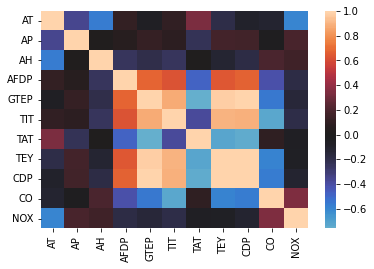

In [13]:
sns.heatmap(df.corr(),center=0)

TIT,TEY,CDP all seem to be highly correlated. CO is strongly negatively correlated with TIT, and positively correlated with AH.

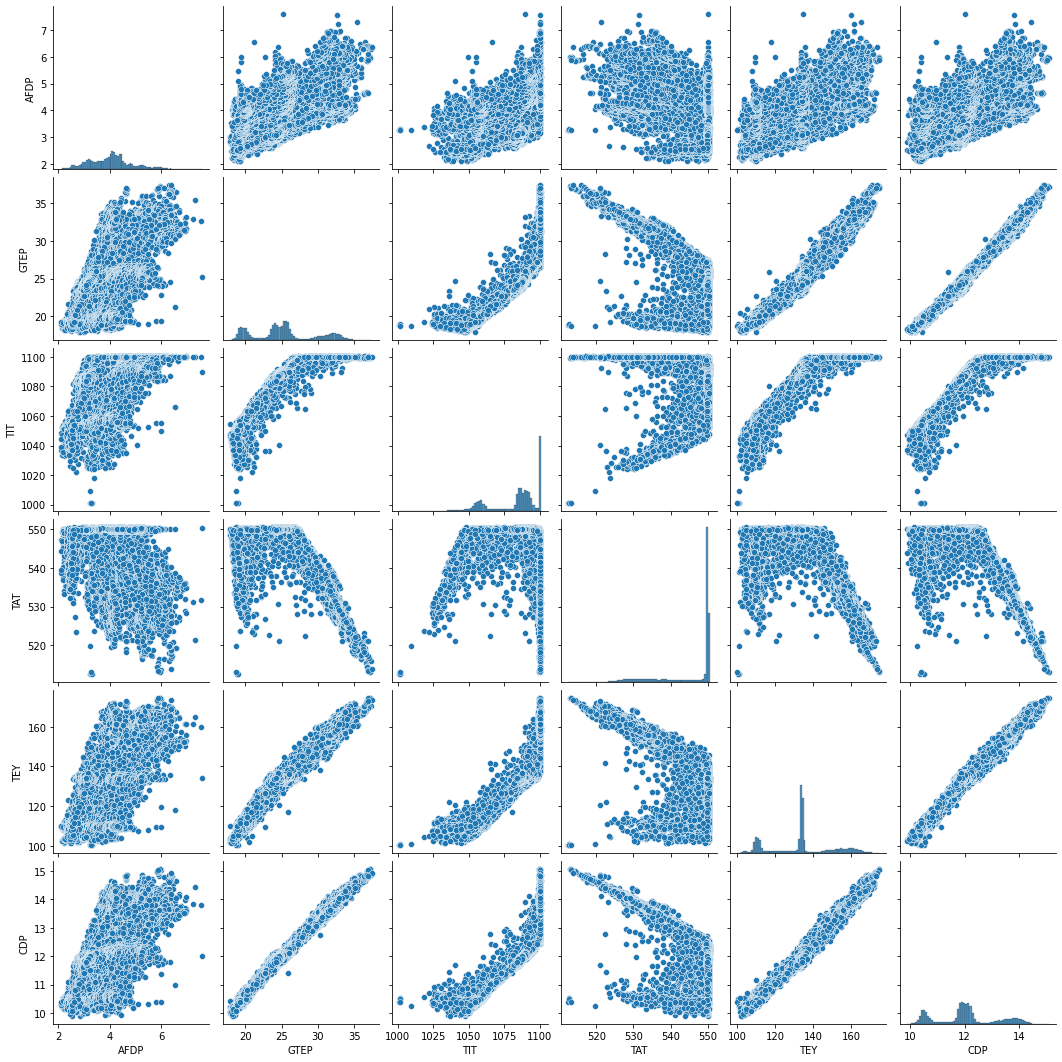

In [14]:
sns.pairplot(df[['AFDP','GTEP','TIT','TAT','TEY','CDP']])

drop GTEP and CDP. 

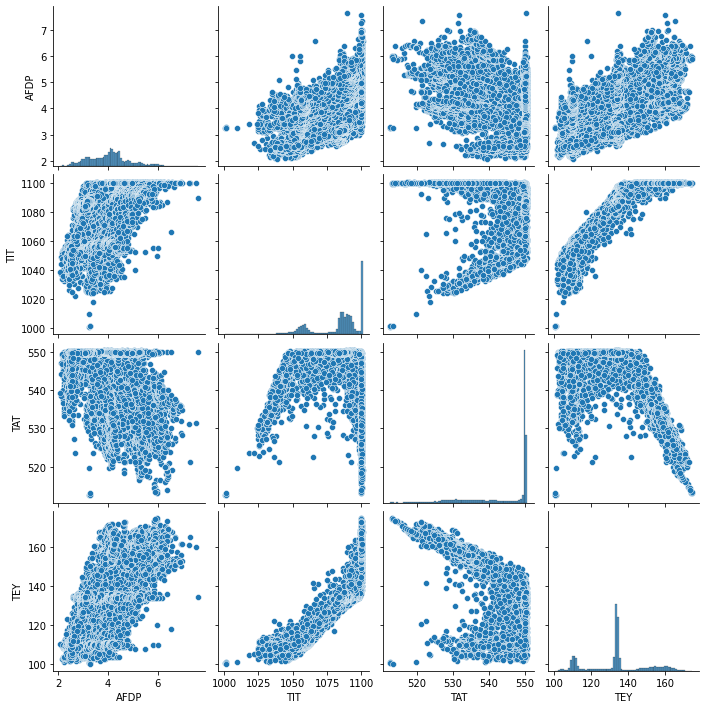

In [15]:
sns.pairplot(df[['AFDP','TIT','TAT','TEY']])

Digitize TAT to get rid of that spike

(array([ 5086.,     0.,     0.,     0.,     0., 11653.,     0.,     0.,
            0.,  5452.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

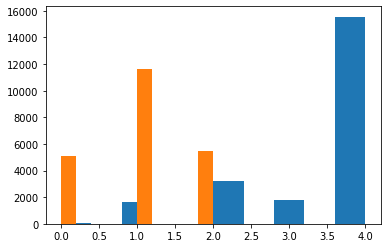

In [16]:
plt.hist(np.digitize(df['TAT'],[520,530,540,548]))
plt.hist(np.digitize(df['TEY'],[120,140]))

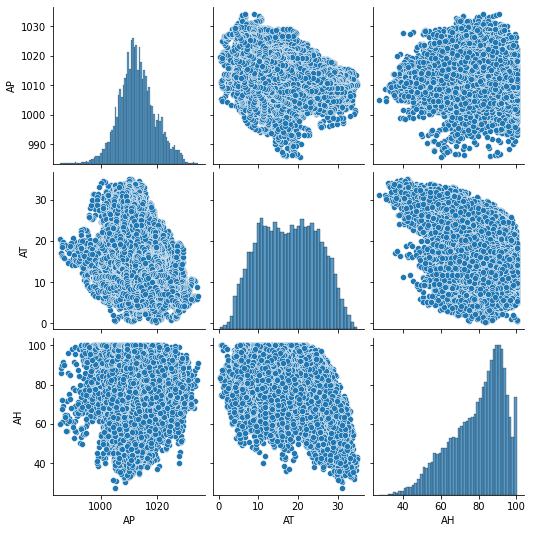

In [17]:
sns.pairplot(df[['AP','AT','AH']])

(array([ 772., 1034., 2698., 4205., 3988., 3335., 2952., 2191.,  906.,
         110.]),
 array([0.54772256, 1.34732727, 2.14693198, 2.94653669, 3.7461414 ,
        4.54574611, 5.34535082, 6.14495553, 6.94456024, 7.74416495,
        8.54376966]),
 <BarContainer object of 10 artists>)

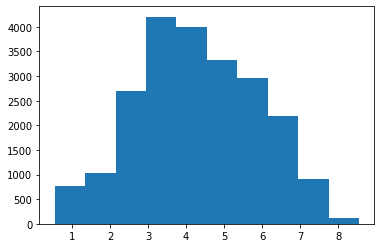

In [18]:
plt.hist(np.sqrt(100.5-df['AH']))

In [19]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

class FeatureEngineer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.m = None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        df_fe = X.copy()
        df_fe['TAT_bin'] = np.digitize(df_fe['TAT'],[520,530,540,548])
#        df_fe['TEY_bin'] = np.digitize(df_fe['TEY'],[120,140])
        df_fe['AH_root'] = np.sqrt(100.5-df_fe['AH'])
        df_fe = df_fe.drop(['GTEP','CDP','TAT','AH'],axis=1)
        
        return df_fe
    
class PandasScaler(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self,X,y=None):
        self.scaler.fit(X.values)
        return self
    
    def transform(self,X):
        self.scaler.transform(X.values)
        return X

In [21]:
from sklearn.pipeline import Pipeline

def engineer_and_regress(filename, regr):

    pl = Pipeline([
        ('feature_engineer',FeatureEngineer()),
        ('scaler', PandasScaler()),
        ('regressor',regr)
    ])

    pl.fit(X,y=T)
    preds = pl.predict(test_df)
    residuals = regr.residuals.copy()

    out = pd.DataFrame(preds, columns=['CO', 'NOX'], index=test_df.index)
    out.to_csv(f'regression/outputs/{filename}')
    
    return regr.residuals
    
residuals = engineer_and_regress("norm_regr_feature_pred.csv", NormalLinearRegressor())
print_r_sq(residuals,T)
evaluate_numeric("norm_regr_feature_pred.csv")

r_sq_nox: 0.47669891514718643
r_sq_co: 0.5756704991442864
RMSE:
CO     0.996501
NOX    6.575720
dtype: float64


Pretty Good!

## 5. Ridge Regression

Ridge regression is a type of regularized regression (using a Quadratic Regularizer), which adds the weights of the coefficients as a penalty in the error term.
$$E = \frac12 \sum_n (t_n - \mathbf{w}^T\phi(\mathbf{x}_n))^2 + \frac{\lambda}{2} \sum_j |w_j|^2$$

Minimizing this gives us the normal form equations as
$$\mathbf{w} = (\lambda\mathbf{I} + \Phi^T \Phi)^{-1} \Phi^T \textbf{t}$$

In [22]:
class RidgeRegressor(BaseEstimator, TransformerMixin):
    
    def __init__(self,l):
        self.w = None
        self.residuals = None
        self.l = l
       
    def fit(self,X,T=None):
        phi = X.to_numpy(copy=True)
        T = T.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        self.w = np.linalg.inv(self.l*np.eye(phi.shape[1]) + phi.T@phi)@phi.T@T
        
        self.residuals = T - self.predict(X)
        return self
        
    def predict(self,X):
        phi = X.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        preds = phi@self.w
        return preds

In [23]:
residuals = regress("quadr_ridge_2.csv", RidgeRegressor(2))
print_r_sq(residuals,T)
evaluate_numeric("quadr_ridge_2.csv")

r_sq_nox: 0.4753377312124054
r_sq_co: 0.5538861652543519
RMSE:
CO     1.815156
NOX    8.753389
dtype: float64


## 6. Gradient Descent, Regularized Regression and Lasso Regression

Regularized Regression is a generalization of Ridge regression which uses the p-norm as the regularizer, rather than the quadratic norm

$$E(\mathbf{w}) = \frac12 \sum_n (t_n - \mathbf{w}^T\phi(\mathbf{x}_n))^2 + \frac{\lambda}{2} \sum_j |w_j|^{\color{red} p}$$

When $p=1$, the regression is called Lasso regression.

If a closed form cannot be obtained for the minima of the error function (like in lasso or generalized regular regression), gradient descent is used to iteratively reach the minima. Gradient descent involved starting from a random point on the function, and then iteratively proceeding in the direction of maximum gradient descent, analogous to 'climbing down a hill'.

$$\mathbf{w}_{n+1} = \mathbf{w}_{n} - \eta\nabla E(\mathbf{w}_n)$$

Here $\eta$ is our descent rate, which is set depending on the rate and accuracy with which we want our algorithm to converge.

For a univariate regression (one target variable),
$$\nabla E = \Phi^T\Phi\mathbf{w} - \Phi^T\textbf{t} + \frac{\lambda p}{2}|\mathbf{w}|^{p-1}*\text{sgn}(\mathbf{w})$$
Whereas for a multivariate regression (multiple target variables)
$$\nabla E = \Phi^T\Phi\mathbf{W} - \Phi^T\textbf{T} + \frac{\lambda p}{2}|\mathbf{W}|^{p-1}*\text{sgn}(\mathbf{W})$$

(* denotes elementwise multiplication)

PS: do give calculating $\nabla E$ a try yourself if you're reading along: will warm up your linear algebra.

In [24]:
class RegularizedRegressor(BaseEstimator, TransformerMixin):
    
    def __init__(self,l,p,eta=0.1,iterations=1000):
        self.w = None
        self.residuals = None
        self.l = l
        self.p = p
        self.eta = eta
        self.iterations = iterations
       
    def fit(self,X,T=None):
        
        # gradient descent on the error function
        
        phi = X.to_numpy(copy=True)
        T = T.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])

        def grad_err(W):
            return phi.T@phi@W - phi.T@T + (self.l*self.p/2)*(np.abs(W)**(self.p-1))*np.sign(W)
        
        self.w = np.zeros((phi.shape[1],T.shape[1]))
        
        for i in range(self.iterations):
            self.w = self.w - self.eta*grad_err(self.w)
            #print(grad_err(self.w))
        
        self.residuals = T - self.predict(X)
        return self
        
    def predict(self,X):
        phi = X.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        preds = phi@self.w
        return preds

In [25]:
rr = RegularizedRegressor(0.5,1,eta=1e-11,iterations=100000)

# takes a bit of time to run
regress("regularized_lasso.csv",rr)

print_r_sq(rr.residuals,T)
evaluate_numeric("regularized_lasso.csv")

r_sq_nox: 0.34266015214543477
r_sq_co: 0.473993569491181
RMSE:
CO      1.059930
NOX    10.990029
dtype: float64


Here's a more _explainable_ run:

[[0.47759929]
 [0.34482202]]


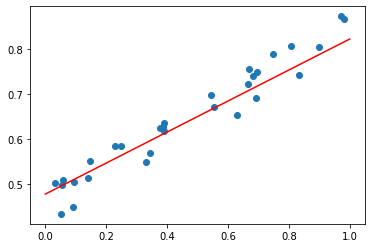

In [26]:
N = 30
x = np.random.random((N,))
e = np.random.uniform(low=0.1,high=0.2,size=(N,))
y = 0.4*x + 0.3 + e

df_pair = pd.DataFrame({"X": x, "Y": y})

regressor = RegularizedRegressor(0.5,1,eta=0.01,iterations=1000)
regressor.fit(df_pair[['X']],df_pair[['Y']])

print(regressor.w)

plt.scatter(x,y)

x = np.linspace(0,1,10)
y = regressor.w[1]*x + regressor.w[0]
plt.plot(x,y,color='r')

## 7. Polynomial Regression

So far, $\phi(\mathbf{x}) = [\begin{matrix}1 & x_1 & \ldots & x_n\end{matrix}]^T$. However, setting $\phi_i(x) = x^i$ would make the resulting relationship polynomial. This is known as polynomial regression: fitting a polynomial to a dataset.

Here's a toy example:

In [27]:
class PolynomialRegressor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.w = None
        self.residuals = None
       
    def fit(self,X,T=None):
        
        # gradient descent on the error function
                
        phi = (X.to_numpy(copy=True))**2
        T = T.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])

        self.w = np.linalg.inv(phi.T@phi)@phi.T@T
        
        self.residuals = T - self.predict(X)
        return self
        
    def predict(self,X):
        phi = X.to_numpy(copy=True)
        phi = np.hstack([np.full((phi.shape[0],1),1),phi])
        
        preds = phi@self.w
        return preds

[[0.45388322]
 [0.38031705]]


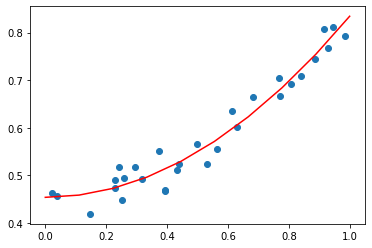

In [28]:
N = 30
x = np.random.random((N,))
e = np.random.uniform(low=0.1,high=0.2,size=(N,))
y = 0.4*(x**2) + 0.3 + e

df_pair = pd.DataFrame({"X": x, "Y": y})

regressor = PolynomialRegressor()
regressor.fit(df_pair[['X']],df_pair[['Y']])

print(regressor.w)

plt.scatter(x,y)

x = np.linspace(0,1,10)
y = regressor.w[1]*(x**2) + regressor.w[0]
plt.plot(x,y,color='r')